In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from time import time

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans

from matplotlib import cm
from nltk.stem import WordNetLemmatizer
import nltk

#nltk.download()

%matplotlib inline

MaxFeature = 10000
MaxTweet = 20000

In [2]:
def load_tweets():
    return pd.read_csv('customer-support-on-twitter/twcs.zip', index_col=0)


tweets = load_tweets()
tweets.head(1202).tail(6)

/opt/devhome/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
tweet_id,,,,,,
1786,AppleSupport,False,Tue Oct 31 22:30:01 +0000 2017,@116107 Glad to hear and just reach out again ...,NaN,1787.0
1787,116107,True,Tue Oct 31 22:10:27 +0000 2017,@AppleSupport Worked 👌🏽,1786,1788.0
1788,AppleSupport,False,Tue Oct 31 21:46:54 +0000 2017,@116107 Please keep us posted afterwards.,1787,1789.0
1789,116107,True,Tue Oct 31 21:32:24 +0000 2017,@AppleSupport No I had 11.0.3 but now it says ...,1788,1790.0
1790,AppleSupport,False,Tue Oct 31 21:30:00 +0000 2017,@116107 Apps are important and we want you to ...,1789,1791.0
1791,116107,True,Tue Oct 31 21:25:20 +0000 2017,why won’t my apps fuccin download or update @A...,1790,NaN


### Field Semantic

- tweet_id: A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.
- author_id: A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.
- inbound: Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.
- created_at: Date and time when the tweet was sent.
- text: Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like __email__.
- response_tweet_id: IDs of tweets that are responses to this tweet, comma-separated.
- in_response_to_tweet_id: ID of the tweet this tweet is in response to, if any.



In [3]:
# Identification of the company providing support via tweeter
# Extract the author_id in the tweets that are not an inbound
tweets.loc[tweets['inbound']==False]['author_id'].unique()

array(['sprintcare', 'Ask_Spectrum', 'VerizonSupport', 'ChipotleTweets',
       'AskPlayStation', 'marksandspencer', 'MicrosoftHelps', 'ATVIAssist',
       'AdobeCare', 'AmazonHelp', 'XboxSupport', 'AirbnbHelp',
       'nationalrailenq', 'AirAsiaSupport', 'Morrisons', 'NikeSupport',
       'AskAmex', 'McDonalds', 'YahooCare', 'AskLyft', 'UPSHelp', 'Delta',
       'AppleSupport', 'Uber_Support', 'Tesco', 'SpotifyCares',
       'British_Airways', 'comcastcares', 'AmericanAir', 'TMobileHelp',
       'VirginTrains', 'SouthwestAir', 'AskeBay', 'hulu_support',
       'GWRHelp', 'sainsburys', 'AskPayPal', 'HPSupport', 'ChaseSupport',
       'CoxHelp', 'DropboxSupport', 'VirginAtlantic', 'BofA_Help',
       'AzureSupport', 'AlaskaAir', 'ArgosHelpers', 'Postmates_Help',
       'AskTarget', 'GoDaddyHelp', 'CenturyLinkHelp', 'AskPapaJohns',
       'SW_Help', 'askpanera', 'Walmart', 'USCellularCares',
       'AsurionCares', 'GloCare', 'idea_cares', 'DoorDash_Help',
       'NeweggService', 'VirginA

In [4]:
# Pick only inbound tweets that aren't in reply to anything...
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]
print('Found {} first inbound messages.'.format(len(first_inbound)))

# Merge in all tweets in response
#inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_on='tweet_id', 
#                                  right_on='in_response_to_tweet_id')
#print("Found {} responses.".format(len(inbounds_and_outbounds)))

inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_index=True, 
                                  right_on='in_response_to_tweet_id')


# Filter out cases where reply tweet isn't from company
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]
inbounds_and_outbounds[inbounds_and_outbounds.author_id_y=='Walmart'][:6]

Found 787346 first inbound messages.


,in_response_to_tweet_id,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
tweet_id,,,,,,,,,,,,,
2378,2380,116254,True,Tue Oct 31 21:53:32 +0000 2017,Just got recognized at @Walmart as the guy who...,2378,NaN,Walmart,False,Tue Oct 31 22:39:02 +0000 2017,"@116254 We disagree, Dylan. We're excited that...",2379,2380
2383,2384,116256,True,Sun Oct 29 05:03:21 +0000 2017,we all know walmart is better in terms of a lo...,2383,NaN,Walmart,False,Sun Oct 29 14:16:20 +0000 2017,"@116256 We ❤️ you too, Angel. Thanks for havin...",2382,2384
2390,2391,116259,True,Tue Oct 31 19:01:20 +0000 2017,It isn’t every day you get 3 carts full of bla...,2390,NaN,Walmart,False,Tue Oct 31 22:08:18 +0000 2017,@116259 We love it! Sounds like a double win! ...,NaN,2391
2392,2393,116260,True,Tue Oct 31 20:34:57 +0000 2017,Used @Walmart #grocerypickup and it's a pretty...,2392,NaN,Walmart,False,Tue Oct 31 22:00:57 +0000 2017,@116260 Yay! We're thrilled to hear you've enj...,NaN,2393
2394,2395,116261,True,Tue Oct 31 20:45:49 +0000 2017,Everybody I’ve met at Walmart is so friendly! ...,2394,NaN,Walmart,False,Tue Oct 31 21:53:49 +0000 2017,@116261 We want you to leave our store with a ...,NaN,2395
2398,2399,116262,True,Tue Oct 31 17:10:30 +0000 2017,Happy Halloween! Look at these pumpkins that w...,2398,NaN,Walmart,False,Tue Oct 31 17:34:28 +0000 2017,@116262 Nothing but the best for the communiti...,2397,2399


In [5]:
# Number of responding tweets authored per company
sorted_answerers=inbounds_and_outbounds.groupby('author_id_y').size().sort_values()

# Total number of responding tweets authored by company
sorted_answerers_sum = sorted_answerers.values.sum()

# Weight of each company in the number of responding tweets
sorted_answerers_sum_percent=sorted_answerers/sorted_answerers_sum*100.0

In [6]:
# Top 20 of the responding companies
sorted_answerers_sum_percent[-20:]

author_id_y
sainsburys          1.355031
AskPlayStation      1.434850
XboxSupport         1.574848
sprintcare          1.592473
ChipotleTweets      1.744054
hulu_support        1.786984
UPSHelp             1.799448
VirginTrains        1.807506
Ask_Spectrum        2.174244
British_Airways     2.468969
TMobileHelp         2.526127
SouthwestAir        2.642078
comcastcares        3.001515
AmericanAir         3.085236
Tesco               3.133203
SpotifyCares        3.391670
Delta               3.586181
Uber_Support        5.039538
AppleSupport        9.395958
AmazonHelp         10.655559
dtype: float64

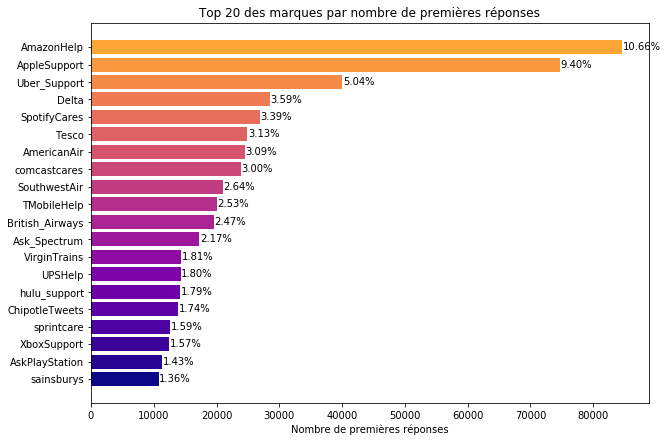

In [7]:
# Plotting the Top 20 of the responding companies

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
pos=np.arange(20)+0.5
plt.figure(figsize=(10,7))
ax = plt.subplot(111)
colors = cm.plasma_r(np.linspace(1,.2, 20))
plt.barh(pos,sorted_answerers.values[-20:],color=colors, tick_label=sorted_answerers.keys()[-20:])
plt.yticks(pos,sorted_answerers.keys()[-20:])
plt.xlabel('Nombre de premières réponses')
plt.title('Top 20 des marques par nombre de premières réponses')
for i, v in enumerate(sorted_answerers.values[-20:]):
    ax.text(v + 100, i + .35, "{:.2f}%".format(sorted_answerers_sum_percent[-20:][i]))

plt.show()

In [8]:
# return the tweet id (in_response_to_tweet_id) authored by author_id in the tweets corpu
def all_tweets_to(tweets, author_id):
    return tweets.loc[pd.unique(tweets.loc[(tweets['inbound']==False) & (tweets['author_id'] == author_id)]['in_response_to_tweet_id'])]

# return the initial tweets in the corpus tweets sent to author_id
def all_initial_tweets_to(tweets, author_id):
    return tweets[(tweets.text.str.contains(author_id)) & (tweets.in_response_to_tweet_id.isnull())]

In [9]:
#all_initial_tweets_to(tweets,'@OfficeSupport')
inbounds_and_outbounds[inbounds_and_outbounds.author_id_y=='Walmart'][:6]

,in_response_to_tweet_id,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
tweet_id,,,,,,,,,,,,,
2378,2380,116254,True,Tue Oct 31 21:53:32 +0000 2017,Just got recognized at @Walmart as the guy who...,2378,NaN,Walmart,False,Tue Oct 31 22:39:02 +0000 2017,"@116254 We disagree, Dylan. We're excited that...",2379,2380
2383,2384,116256,True,Sun Oct 29 05:03:21 +0000 2017,we all know walmart is better in terms of a lo...,2383,NaN,Walmart,False,Sun Oct 29 14:16:20 +0000 2017,"@116256 We ❤️ you too, Angel. Thanks for havin...",2382,2384
2390,2391,116259,True,Tue Oct 31 19:01:20 +0000 2017,It isn’t every day you get 3 carts full of bla...,2390,NaN,Walmart,False,Tue Oct 31 22:08:18 +0000 2017,@116259 We love it! Sounds like a double win! ...,NaN,2391
2392,2393,116260,True,Tue Oct 31 20:34:57 +0000 2017,Used @Walmart #grocerypickup and it's a pretty...,2392,NaN,Walmart,False,Tue Oct 31 22:00:57 +0000 2017,@116260 Yay! We're thrilled to hear you've enj...,NaN,2393
2394,2395,116261,True,Tue Oct 31 20:45:49 +0000 2017,Everybody I’ve met at Walmart is so friendly! ...,2394,NaN,Walmart,False,Tue Oct 31 21:53:49 +0000 2017,@116261 We want you to leave our store with a ...,NaN,2395
2398,2399,116262,True,Tue Oct 31 17:10:30 +0000 2017,Happy Halloween! Look at these pumpkins that w...,2398,NaN,Walmart,False,Tue Oct 31 17:34:28 +0000 2017,@116262 Nothing but the best for the communiti...,2397,2399


In [10]:
apple = inbounds_and_outbounds[inbounds_and_outbounds.author_id_y=='AppleSupport']
print(apple.iloc[2].text_x)
print()
print(apple.iloc[3].text_x)
print()
print(apple.iloc[5].text_x)
print()

@115858 @AppleSupport hello are all the lines closed for tonight #help

Hello, internet. Can someone explain why this symbol keeps appearing on my phone and when I️ try to type the letter I️? Also @AppleSupport https://t.co/QKwvTLtiN7

Thank you @AppleSupport I updated my phone and now it is even slower and barely works. Thank you for ruining my phone.😤



In [11]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re 
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')

tknzr = TweetTokenizer(preserve_case=False)

def preprocess_tweet(tweet):
    #import string
    #tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '<url>', tweet)  # URLs
    #tweet = re.sub(r'(?:@[\d]+)', '<user>', tweet)  # numeric user-mentions
    #tweet = re.sub(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)', '<hashtag>', tweet)  # hashtags
    #tweet = re.sub(r'(?:(?:\d+,?)+(?:\.?\d+)?)', '<number>', tweet)  # numbers
    
   # translate_table = dict((ord(char), None) for char in string.punctuation)   
    
    #return tweet.translate(translate_table)
    #return tweet
    #return " ".join([snowball_stemmer.stem(word) for word in tweet.split(" ")])
    return " ".join([wordnet_lemmatizer.lemmatize(word) for word in tweet.lower().split(" ")])


## Build the feature Vector based on TF-IDF. 
# min_df = 2 <=> minimum 2 occurences of the word

url_regex = '(?:http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+)|\b\w+'
tweet_regex=r"(?u)"+ url_regex+"|(?:(?:\w|[@#])\w+)"

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=MaxFeature,stop_words='english', analyzer = 'word',
                             tokenizer=None, preprocessor=None ,token_pattern=tweet_regex, 
                             lowercase = True)


X = vectorizer.fit_transform(apple.text_x[:MaxTweet])

## X contains per tweet(row)
print("n_samples: %d, n_features: %d" % X.shape)

# it is interesting to look at the feature name with 
#print (vectorizer.get_feature_names())

n_samples: 20000, n_features: 6939


In [12]:
# le but de cette cellule est de tuner la tokenisation

# 2 3 ou 5
test_text = apple.iloc[3].text_x
print(test_text)
print()
print(tknzr.tokenize(test_text))
print()

token_pattern = re.compile(r"(?u)\b\w\w+\b")
print(token_pattern.findall(test_text))
print()

url_regex = '(?:http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+)|\b\w+'
#token_pattern = re.compile(r"(?u)"+ url_regex+"|(?:(?:\b\w|\B[@#])\w+\b)")
token_pattern = re.compile(r"(?u)"+ url_regex+"")
print(token_pattern.findall(test_text))


Hello, internet. Can someone explain why this symbol keeps appearing on my phone and when I️ try to type the letter I️? Also @AppleSupport https://t.co/QKwvTLtiN7

['hello', ',', 'internet', '.', 'can', 'someone', 'explain', 'why', 'this', 'symbol', 'keeps', 'appearing', 'on', 'my', 'phone', 'and', 'when', 'i', '️', 'try', 'to', 'type', 'the', 'letter', 'i', '️', '?', 'also', '@applesupport', 'https://t.co/QKwvTLtiN7']

['Hello', 'internet', 'Can', 'someone', 'explain', 'why', 'this', 'symbol', 'keeps', 'appearing', 'on', 'my', 'phone', 'and', 'when', 'try', 'to', 'type', 'the', 'letter', 'Also', 'AppleSupport', 'https', 'co', 'QKwvTLtiN7']

['https://t.co/QKwvTLtiN7']


In [13]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
stopWords.add('@AppleSupport')
stopWords.add('@applesupport')
stopWords.add('@115858')

vectorizer = TfidfVectorizer(max_df=0.9, min_df=1, max_features=MaxFeature,stop_words=stopWords, analyzer = 'word',
                             tokenizer=None, preprocessor=None,token_pattern=tweet_regex, 
                             lowercase = True)

X = vectorizer.fit_transform(apple.text_x)
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 74632, n_features: 10000


In [14]:
vectorizer2grams = TfidfVectorizer(ngram_range=(1,2),max_df=0.9, min_df=1, max_features=MaxFeature, analyzer = 'word',
                                   stop_words=stopWords, tokenizer=None, preprocessor=None,
                                   token_pattern=tweet_regex,
                                   lowercase = True)

X2 = vectorizer2grams.fit_transform(apple.text_x)
print("n_samples: %d, n_features: %d" % X2.shape)

n_samples: 74632, n_features: 10000


In [15]:


## Display the list of the n_top_words main features pull out of the feature_names dictionnary for each centroids
def print_top_words(centroids, feature_names, n_top_words=-1):
    for topic_idx, topic in enumerate(centroids):
        if (n_top_words == -1):
            nbfeature = 10
        else:
            nbfeature = n_top_words
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-nbfeature - 1:-1]]))
    print()
    
    


def print_top_words_histo(centroids, feature_names, n_top_words):
    colors = cm.plasma_r(np.linspace(.2,1, 20))
    plt.figure(figsize=(12,6))
#    y = np.linspace(1,10,10)
    
    for topic_idx, topic in enumerate(centroids):
        plt.subplot(2, centroids.shape[0]/2,topic_idx+1)
        plt.title("Topic #%d:" % topic_idx)
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        weights = [topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
#        plt.barh(y,weights, tick_label=words)
        plt.barh(range(n_top_words,0,-1),width=weights, tick_label=words, color=colors)
    plt.tight_layout()

    plt.show()


In [16]:


# Do the actual clustering with online K-Means
nb_of_topics = 10
km = MiniBatchKMeans(n_clusters=nb_of_topics, init='k-means++', n_init=1,
                     init_size=1000, batch_size=500, verbose=0,  random_state=2018)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

# Look at terms that are the most present in each class
feature_names = vectorizer.get_feature_names()
n_top_words = 10

print("\nTopics in K-means model:")



Clustering sparse data with MiniBatchKMeans(batch_size=500, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=2018, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.287s

Topics in K-means model:


Topic #0:
iphone battery new plus 6s keeps screen phone get update
Topic #1:
update phone new since battery ios iphone latest last fix
Topic #2:
11 ios battery iphone phone since update fix updated life
Topic #3:
fix please glitch problem issue letter going gonna need hey
Topic #4:
thanks sierra high update phone new iphone mac macos hey
Topic #5:
apple wtf get hey letter type like going time #ios11
Topic #6:
phone updated new since still wtf like keeps screen battery
Topic #7:
shit question mark fix box together get marks letter phone
Topic #8:
app music apple store download @115948 open update play get
Topic #9:
help please need iphone phone update new apple hi pls



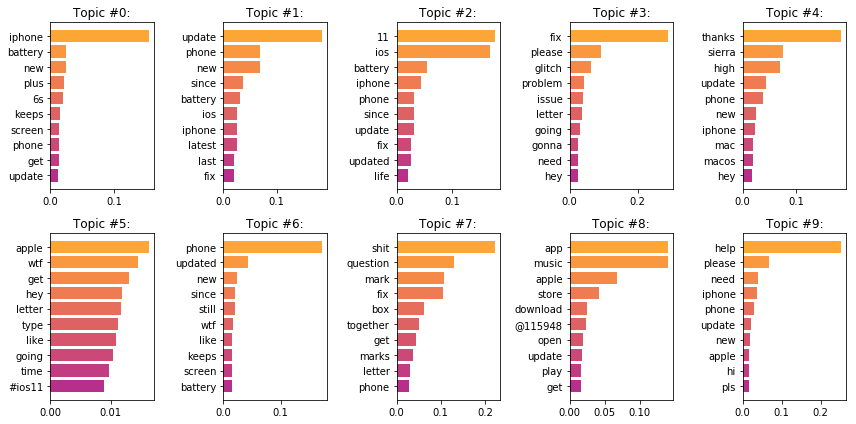

In [17]:
print_top_words(km.cluster_centers_, feature_names, n_top_words)
#for k, centroid in enumerate(km.cluster_centers_):
#    print("Cluster #%d:" % k)
#    print(" ".join([feature_names[i]
#                    for i in centroid.argsort()[:-n_top_words - 1:-1]]))

print_top_words_histo(km.cluster_centers_, feature_names, n_top_words)

## NMF - monogrammes

In [18]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=nb_of_topics, random_state=2018,
          alpha=.1, l1_ratio=.5).fit(X)


Topic #0:
ios 11 battery life since updated draining 10 updating 6s
Topic #1:
fix please glitch problem issue going gonna hey bug need
Topic #2:
phone updated since freezing keeps ever still keep fucking amp
Topic #3:
help please need hi pls send someone dm macbook could
Topic #4:
question mark box marks boxes seeing still updated see keep
Topic #5:
iphone apple music app screen plus working 6s get like
Topic #6:
shit get together fucking need fuck yo tired annoying fix
Topic #7:
update new battery latest since software last thanks apps sucks
Topic #8:
wtf going wrong yo like seriously happening bro okay thing
Topic #9:
letter type time every eye going glitch hey weird without



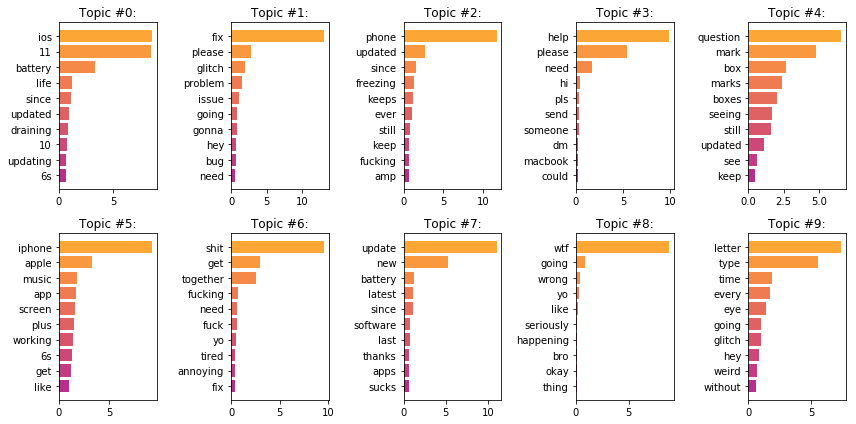

In [19]:
print_top_words(nmf.components_, feature_names, n_top_words)
print_top_words_histo(nmf.components_, feature_names, n_top_words)

## NMF - bigrammes

In [20]:
from sklearn.decomposition import NMF
nmf2 = NMF(n_components=nb_of_topics,
          alpha=.1, l1_ratio=.5).fit(X2)

Topic #0:
11 ios ios 11 11 update updated ios battery updated since updating new ios
Topic #1:
fix glitch problem fix glitch fix problem need fix going fix going need gonna
Topic #2:
phone update new new update since update phone updated ever ios update updated phone
Topic #3:
help please help need need help help please please pls pls help hi need fix
Topic #4:
question mark question mark box letter type mark box marks question marks boxes
Topic #5:
shit fix shit get together shit together get shit fucking fuck yo get together
Topic #6:
iphone battery life battery life plus 6s iphone 6s iphone plus new iphone new
Topic #7:
apple music apple music app watch store apple watch id get apple id
Topic #8:
wtf wtf going going wtf wrong yo wtf wtf shit like wtf wrong wtf fix yo
Topic #9:
please please fix please help fix please dear dear please issue fix help please fix issue



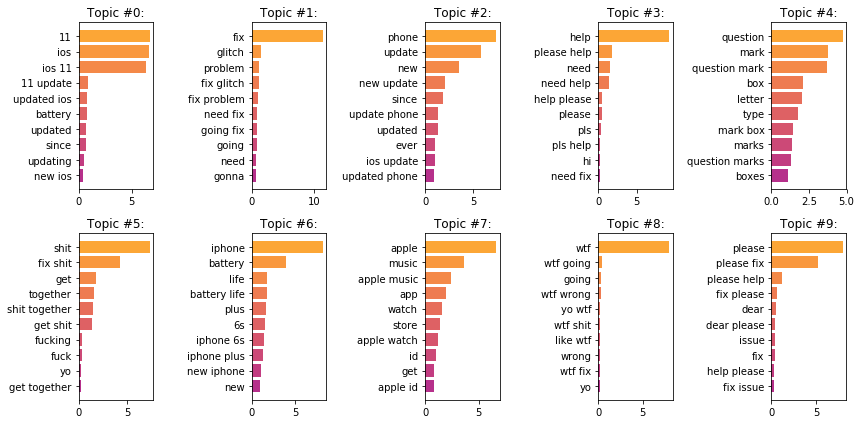

In [21]:
print_top_words(nmf2.components_, vectorizer2grams.get_feature_names(), n_top_words)
print_top_words_histo(nmf2.components_, vectorizer2grams.get_feature_names(), n_top_words)

## NMF sur les réponses

In [22]:
vectorizerAnswers = TfidfVectorizer(max_df=0.9, min_df=1, max_features=10000,stop_words=stopWords, tokenizer=None, preprocessor=None,token_pattern=tweet_regex,)

X_answers = vectorizerAnswers.fit_transform(apple.text_y)
print("n_samples: %d, n_features: %d" % X_answers.shape)

n_samples: 74632, n_features: 10000


In [23]:
nmf_answers = NMF(n_components=nb_of_topics,
          alpha=.1, l1_ratio=.5).fit(X_answers)

Topic #0:
us dm https://t.co/gdrqu22ypt send like help details continue please go
Topic #1:
around future fixed software https://t.co/xxaxeesrt9 update work issue https://t.co/qodbosp4wz https://t.co/uqexsrrlxj
Topic #2:
version ios using iphone running device currently help installed 11
Topic #3:
english twitter https://t.co/ibiy3vmgpj support offer via preferred language contact join
Topic #4:
thanks reaching workaround still need us help https://t.co/xxaxeesrt9 dm https://t.co/gdrqu22ypt
Topic #5:
gt settings general version ios check running find go currently
Topic #6:
look take together dm https://t.co/gdrqu22ypt closer us let happy reach
Topic #7:
get started happy reach dm https://t.co/gdrqu22ypt please via detail us
Topic #8:
let know us https://t.co/gdrqu22ypt dm together steps help important try
Topic #9:
back 11 released update device https://t.co/4f8hwt5to6 issues ios updating recently



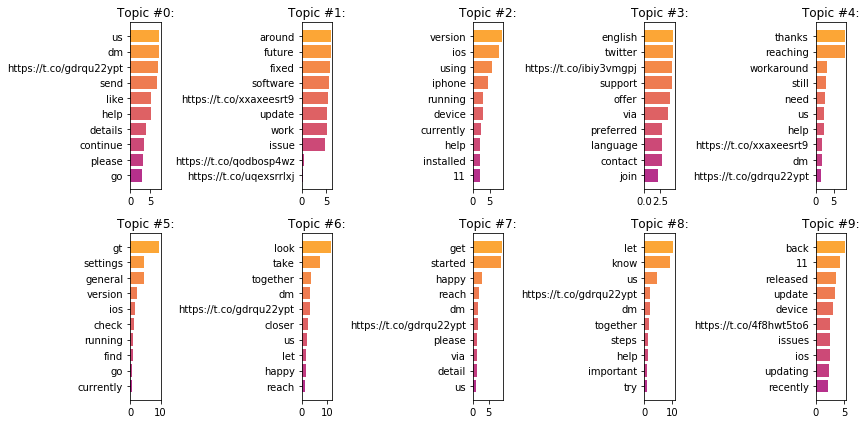

In [24]:
print_top_words(nmf_answers.components_, vectorizerAnswers.get_feature_names(), n_top_words)
print_top_words_histo(nmf_answers.components_, vectorizerAnswers.get_feature_names(), n_top_words)

## LDA - Latent Dirichlet Allocation

In [25]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=MaxFeature,
                                stop_words=stopWords, preprocessor=None, token_pattern=tweet_regex, 
                                lowercase = True, analyzer = 'word')
X_tf = tf_vectorizer.fit_transform(apple.text_x)
lda = LatentDirichletAllocation(n_components=nb_of_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=2018)
t0 = time()
lda.fit(X_tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()

done in 54.294s.

Topics in LDA model:


Topic #0:
battery problem life day iphone times ios11 11 ios draining
Topic #1:
phone time every keeps ever keep iphone fuck really since
Topic #2:
apple one iphone got hi watch get store service buy
Topic #3:
app iphone 10 back slow go ipad macbook update know
Topic #4:
get like update issues phone work screen anyone new guys
Topic #5:
ios 11 update iphone phone amp new since music updated
Topic #6:
fix please shit phone letter question type going make update
Topic #7:
fix need glitch working issue annoying help text phone something
Topic #8:
help screen please icloud photos itunes try bug able message
Topic #9:
updates turn hours wifi de think iphone fast que order



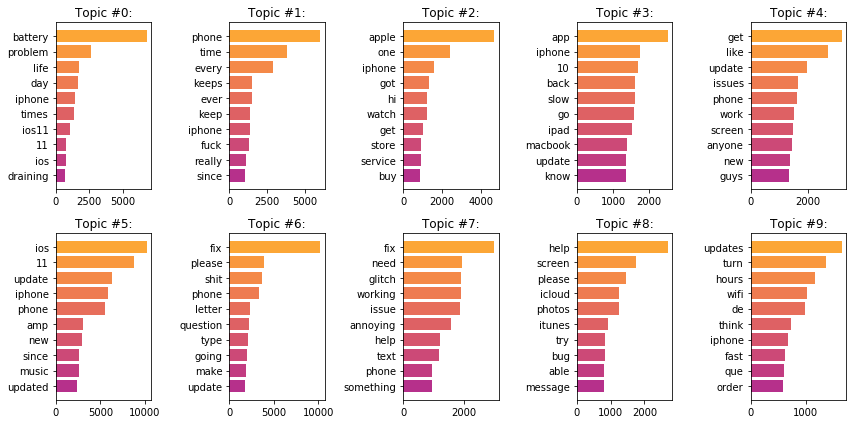

In [26]:
print_top_words(lda.components_, tf_feature_names, n_top_words)
print_top_words_histo(lda.components_, tf_feature_names, n_top_words)

In [28]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X_tf, tf_vectorizer, mds='tsne')
panel

/opt/devhome/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
5      16.777133        1       1  124.797379  104.190102
3      11.928509        1       2   89.394737  -80.230629
4      11.136456        1       3  -60.343662   72.741035
6      10.456985        1       4  -19.500927  -37.053741
1       9.724708        1       5 -132.216187   -2.362068
8       9.091177        1       6   16.277645  142.992798
2       9.030640        1       7  -95.740440 -111.685951
7       8.663909        1       8   48.553795   29.562164
0       7.126903        1       9   12.779173 -150.486649
9       6.063580        1      10  161.271774   -5.133529, topic_info=     Category          Freq           Term         Total  loglift  logprob
term                                                                      
4093  Default  12476.000000            fix  12476.000000  30.0000  30.0000
1912  Default   6890.000000        battery   6890.000000  29.0000  29.0000
5156  Default  10944.000000            ios  10944.000000  28.0000  28.0000
550   Default   9424.000000             11   9424.000000  27.0000  27.0000
1534  Default   6213.000000          apple   6213.000000  26.0000  26.0000
6686  Default  17543.000000          phone  17543.000000  25.0000  25.0000
8904  Default   3716.000000           time   3716.000000  24.0000  24.0000
6766  Default   6186.000000         please   6186.000000  23.0000  23.0000
7943  Default   3814.000000           shit   3814.000000  22.0000  22.0000
6961  Default   2687.000000        problem   2687.000000  21.0000  21.0000
3797  Default   2786.000000          every   2786.000000  20.0000  20.0000
4702  Default   5347.000000           help   5347.000000  19.0000  19.0000
9300  Default  12033.000000         update  12033.000000  18.0000  18.0000
4393  Default   5066.000000            get   5066.000000  17.0000  17.0000
5539  Default   3531.000000           like   3531.000000  16.0000  16.0000
6384  Default   2299.000000            one   2299.000000  15.0000  15.0000
1448  Default   2990.000000            amp   2990.000000  14.0000  14.0000
9302  Default   1792.000000        updates   1792.000000  13.0000  13.0000
7766  Default   3062.000000         screen   3062.000000  12.0000  12.0000
5505  Default   2146.000000         letter   2146.000000  11.0000  11.0000
5216  Default   2678.000000          issue   2678.000000  10.0000  10.0000
5524  Default   1795.000000           life   1795.000000   9.0000   9.0000
9758  Default   2543.000000        working   2543.000000   8.0000   8.0000
7130  Default   2042.000000       question   2042.000000   7.0000   7.0000
1522  Default   3312.000000            app   3312.000000   6.0000   6.0000
6153  Default   2964.000000           need   2964.000000   5.0000   5.0000
6099  Default   2518.000000          music   2518.000000   4.0000   4.0000
4430  Default   1821.000000         glitch   1821.000000   3.0000   3.0000
3044  Default   1663.000000            day   1663.000000   2.0000   2.0000
9145  Default   1928.000000           type   1928.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
3047  Topic10   1072.329516             de   1073.190676   2.8021  -3.6979
8841  Topic10    800.870702          think    801.731995   2.8018  -3.9898
3969  Topic10    669.737412           fast    670.598690   2.8016  -4.1686
7108  Topic10    651.981007            que    652.842152   2.8015  -4.1955
6426  Topic10    641.179025          order    642.040280   2.8015  -4.2122
7784  Topic10    596.479501             se    597.340709   2.8014  -4.2844
5392  Topic10    579.450043             la    580.311201   2.8014  -4.3134
1750  Topic10    551.798989           auto    552.660338   2.8013  -4.3623
3479  Topic10    485.487461         drains    486.348712   2.8011  -4.4903
1761  Topic10    416.642113  automatically    417.503360   2.8008  -4.6432
4815  Topic10    387.593502       ho

## DBSCAN

In [29]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

MaxFeature = 10000
MaxTweet = 20000

url_regex = '(?:http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+)|\b\w+'
tweet_regex=r"(?u)"+ url_regex+"|(?:(?:\w|[@#])\w+)"
vectorizer = TfidfVectorizer(max_df=1, min_df=1, max_features=MaxFeature,stop_words=stopWords, 
                             tokenizer=None, preprocessor=preprocess_tweet, token_pattern=tweet_regex,
                             analyzer = 'word', ngram_range = (1,1), 
                             lowercase = True)

#vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=MaxFeature,stop_words=stopWords, 
#                             tokenizer=None, preprocessor=None, token_pattern=tweet_regex,
#                             lowercase=True, analyzer = 'word', ngram_range = (1,1))

X = vectorizer.fit_transform(apple.text_x[:MaxTweet])
feature_names = vectorizer.get_feature_names()


## X contains per tweet(row)
print("n_samples: %d, n_features: %d" % X.shape)



<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:9: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:9: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:9: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:9: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:9: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:9: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \(
<input>:9: DeprecationWarning: invalid escape sequence \w
<input>:8: Dep

n_samples: 20000, n_features: 10000


DBSCAN est une méthode de clusturisation qui requiert la définition de deux hyper-paramêtres :
- epsilon la distance autour du point pour évaluer la densité
- Min-Sample : le nombre minimum de point dans le voisinage epsilon pour considérer que le voisinage est dense

Afin de déterminer ces hyperparamêtres, je vais effectuer une recherche

In [30]:

epsilon_samples = 9
min_samples = 5
epsilon_range =  np.logspace(-5, 3, epsilon_samples)
min_samples_range = [3, 5, 8, 10, 15] #np.linspace(5, 15, min_samples)

# Création d'un Data Frame pour Stocker les données résultats
Resultat_DBSCAN = pd.DataFrame()
scores = np.zeros([epsilon_samples,min_samples,3])

idx = 0
for eps_idx in epsilon_range :
    idy = 0
    for min_samples_idx in min_samples_range:
        DBSCANIteration = pd.Series(name='DBSCAN')
        DBSCANIteration['eps'] = eps_idx
        DBSCANIteration['min_spl'] = min_samples_idx

        dbscan = DBSCAN(eps=eps_idx, min_samples=min_samples_idx)
        
        t0 = time()
        dbscan.fit(X[:MaxTweet,:]) #dbscan.fit(X[:MaxTweet,:MaxFeature])
        DBSCANIteration['exec_time'] = time() - t0
        
        print ("eps_idx, min_samples_idx, time :", eps_idx, min_samples_idx, DBSCANIteration['exec_time'])

        core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
        core_samples_mask[dbscan.core_sample_indices_] = True
        labels = dbscan.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        DBSCANIteration['number of clusters'] = n_clusters_

        DBSCANIteration['Number of labels'] = labels.shape

        DBSCANIteration['Number of unique labels'] = np.unique(labels).size
        scores[idx, idy,2] = DBSCANIteration['Number of unique labels']

        t0 = time()        
        if  ((np.unique(labels).size)>1):
            DBSCANIteration['Silhouette Coef'] = metrics.silhouette_score(X[:MaxTweet,:], labels)
            scores[idx, idy,0] = DBSCANIteration['Silhouette Coef']
            DBSCANIteration['calinski harabaz'] = metrics.calinski_harabaz_score(X[:MaxTweet,:].toarray(), labels)
            scores[idx, idy,1] = DBSCANIteration['calinski harabaz']
        else:
            DBSCANIteration['Silhouette Coef'] = -1
            scores[idx, idy,0] = DBSCANIteration['Silhouette Coef']
            DBSCANIteration['calinski harabaz'] = 0
            scores[idx, idy,1] = DBSCANIteration['calinski harabaz']

        print("Time for scoring : ", time() - t0)    
        
        Resultat_DBSCAN = Resultat_DBSCAN.append(DBSCANIteration)
        idy += 1
    idx += 1
    
        


eps_idx, min_samples_idx, time : 1e-05 3 5.60435032845
Time for scoring :  13.933585405349731
eps_idx, min_samples_idx, time : 1e-05 5 4.76496911049
Time for scoring :  13.589195966720581
eps_idx, min_samples_idx, time : 1e-05 8 4.77598190308
Time for scoring :  13.707439184188843
eps_idx, min_samples_idx, time : 1e-05 10 5.26536440849
Time for scoring :  14.52355670928955
eps_idx, min_samples_idx, time : 1e-05 15 5.00992155075
Time for scoring :  13.91169786453247
eps_idx, min_samples_idx, time : 0.0001 3 4.78208327293
Time for scoring :  13.792685508728027
eps_idx, min_samples_idx, time : 0.0001 5 4.79497313499
Time for scoring :  13.949486017227173
eps_idx, min_samples_idx, time : 0.0001 8 4.78849673271
Time for scoring :  13.723469734191895
eps_idx, min_samples_idx, time : 0.0001 10 4.87172222137
Time for scoring :  13.817270278930664
eps_idx, min_samples_idx, time : 0.0001 15 4.77712988853
Time for scoring :  13.925013780593872
eps_idx, min_samples_idx, time : 0.001 3 4.8366732597

In [31]:
Resultat_DBSCAN = Resultat_DBSCAN[['eps',
                         'min_spl',
                         'exec_time',
                         'number of clusters',
                         'Number of labels',
                         'Number of unique labels',
                         'Silhouette Coef',
                         'calinski harabaz']].sort_values(by='number of clusters', ascending=False).head(30)

display(Resultat_DBSCAN)

a = Resultat_DBSCAN[['eps','min_spl','Silhouette Coef', 'calinski harabaz']]


,eps,min_spl,exec_time,number of clusters,Number of labels,Number of unique labels,Silhouette Coef,calinski harabaz
DBSCAN,0.00001,3.0,5.604350,1.0,"(20000,)",2.0,0.585046,2.115868
DBSCAN,0.10000,10.0,4.842179,1.0,"(20000,)",2.0,0.585046,2.115868
DBSCAN,1.00000,3.0,5.855742,1.0,"(20000,)",2.0,0.532400,2.991843
DBSCAN,1.00000,5.0,5.869232,1.0,"(20000,)",2.0,0.532400,2.991843
DBSCAN,1.00000,8.0,5.889023,1.0,"(20000,)",2.0,0.532400,2.991843
DBSCAN,1.00000,10.0,5.735171,1.0,"(20000,)",2.0,0.532400,2.991843
DBSCAN,1.00000,15.0,5.758211,1.0,"(20000,)",2.0,0.532400,2.991843
DBSCAN,10.00000,3.0,5.845347,1.0,"(20000,)",1.0,-1.000000,0.000000
DBSCAN,10.00000,5.0,5.740522,1.0,"(20000,)",1.0,-1.000000,0.000000
DBSCAN,10.00000,8.0,5.863422,1.0,"(20000,)",1.0,-1.000000,0.000000


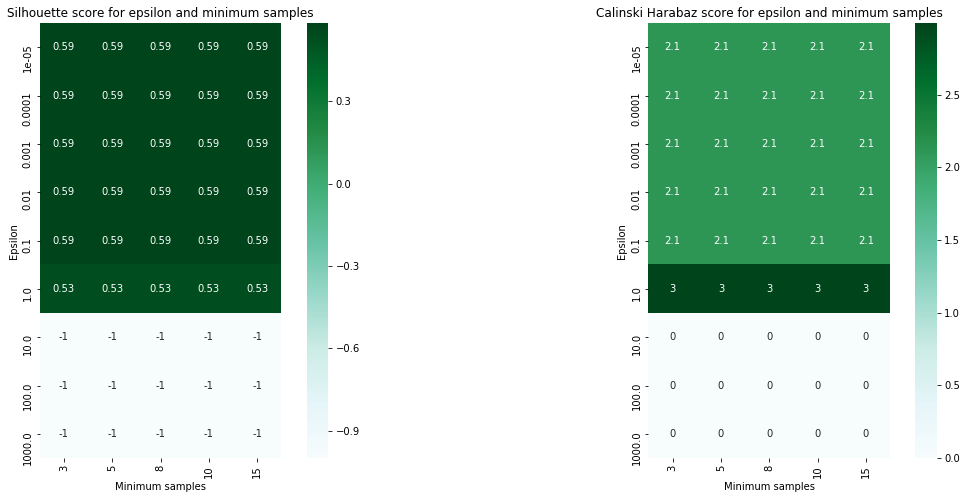

In [32]:
# Draw heatmap of

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
#sns.heatmap(a, ax=axs, square=True, annot=True, cmap=plt.cm.BuGn)
sns.heatmap(scores[:,:,0], ax=axs[0], square=True, annot=True, cmap=plt.cm.BuGn)
axs[0].set_title("Silhouette score for epsilon and minimum samples")
axs[0].set_ylabel('Epsilon')
axs[0].set_xlabel('Minimum samples')
axs[0].set_xticklabels(min_samples_range, rotation=90)
axs[0].set_yticklabels(epsilon_range)


#sns.heatmap(a, ax=axs, square=True, annot=True, cmap=plt.cm.BuGn)
sns.heatmap(scores[:,:,1], ax=axs[1], square=True, annot=True, cmap=plt.cm.BuGn)
axs[1].set_title("Calinski Harabaz score for epsilon and minimum samples")
axs[1].set_ylabel('Epsilon')
axs[1].set_xlabel('Minimum samples')
axs[1].set_xticklabels(min_samples_range, rotation=90)
axs[1].set_yticklabels(epsilon_range)

plt.show()


In [33]:
import scipy.sparse as sparse_mat

print("Best Eps: ", a.iloc[0]['eps'])
print("Best Min_Sample: ", a.iloc[0]['min_spl'])
dbscan = DBSCAN(eps=a.iloc[0]['eps'], min_samples=a.iloc[0]['min_spl'])


t0 = time()
dbscan.fit(X[:MaxTweet,:])
print("done in %0.3fs." % (time() - t0))

#core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
#core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("\nTopics in DBSCAN model:")

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X[:MaxTweet,:], labels))

print("ratio between the within-cluster dispersion and the between-cluster dispersion: %0.3f"
      % metrics.calinski_harabaz_score(X[:MaxTweet,:].toarray(), labels))  


Best Eps:  1e-05
Best Min_Sample:  3.0
done in 4.610s.

Topics in DBSCAN model:
Estimated number of clusters: 1
Silhouette Coefficient: 0.585
ratio between the within-cluster dispersion and the between-cluster dispersion: 2.116


In [34]:
## Display the list of the n_top_words main features pull out of the feature_names dictionnary for each centroids
def print_top_words_hierarchic(model, topic_max=10, n_top_words=10):

    for topic_idx in range(topic_max):
        #extract the samples belonging to the cluster
        
        corpus = apple.text_x[:MaxTweet]
        corpus = corpus[model.labels_== topic_idx]
        print ("Corpus shape :", corpus.shape)
##        print ("model.label :", model.labels_)
        
        if (corpus.shape[0]>0):
            print("Topic #%d:" % topic_idx)
            Topicvectorizer = TfidfVectorizer(max_df=100, min_df=1, max_features=MaxFeature,stop_words=stopWords, 
                                     tokenizer=None, preprocessor=None,token_pattern=tweet_regex, 
                                     lowercase = True, analyzer = 'word')
            
            Topicvectorizer.fit_transform(corpus)
            #nbtoken = min(n_top_words, corpus.shape[0])
            a = ""
            for i in Topicvectorizer.idf_.argsort()[:n_top_words]:
                a = a + " " + Topicvectorizer.get_feature_names()[i]
            print(a)
    
def print_top_words_hierarchic_histo(model, topic_max=10, n_top_words=10):
    
    colors = cm.plasma_r(np.linspace(.2,1, 20))
    plt.figure(figsize=(12,16))

    y = np.linspace(1,10,10)
    
    for topic_idx in range(topic_max):

        corpus = apple.text_x[:MaxTweet]
        corpus = corpus[model.labels_== topic_idx]

        if (corpus.shape[0]>0):

            Topicvectorizer = TfidfVectorizer(max_df=100, min_df=1, max_features=MaxFeature,stop_words=stopWords, 
                                             tokenizer=None, preprocessor=None,token_pattern=tweet_regex,
                                             lowercase = True, analyzer = 'word')

            Topicvectorizer.fit_transform(corpus)

            plt.subplot(topic_max/2, 2,topic_idx+1)
            plt.xlim (0, 10)
            plt.title("Topic #%d:" % topic_idx)
            words = [Topicvectorizer.get_feature_names()[i] for i in Topicvectorizer.idf_.argsort()[:n_top_words]]
            weights = [Topicvectorizer.idf_[i] for i in Topicvectorizer.idf_.argsort()[:n_top_words]]
            ymax = min(Topicvectorizer.idf_.argsort().shape[0],n_top_words)
            y = np.linspace(1,ymax,ymax)
            plt.barh(y,weights, tick_label=words, color=colors)
            #plt.barh(y, weights, tick_label=words)
    plt.tight_layout()
    plt.show()



Corpus shape : (13581,)
Topic #0:
 think great asap happened data weeks needs showing first brightness
Corpus shape : (0,)
Corpus shape : (0,)
Corpus shape : (0,)
Corpus shape : (0,)
Corpus shape : (0,)
Corpus shape : (0,)
Corpus shape : (0,)
Corpus shape : (0,)
Corpus shape : (0,)


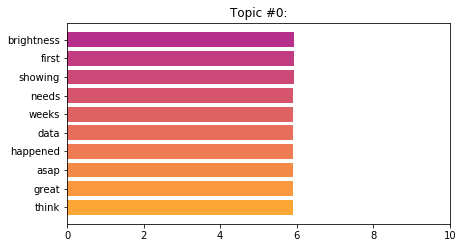

In [35]:
print_top_words_hierarchic(dbscan, topic_max=10, n_top_words=10)
print_top_words_hierarchic_histo(dbscan, topic_max=10, n_top_words=10)

## Hierarchical Agglomerative Clustering

In [38]:
MaxFeature = 10000
MaxTweet = 10000
from nltk import word_tokenize

from nltk.stem import PorterStemmer

def word_tokenizer(text):
        #tokenizes and stems the text
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in tokens if t not in stopWords]
    return tokens


url_regex = '(?:http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+)|\b\w+'
tweet_regex=r"(?u)"+ url_regex+"|(?:(?:\w|[@#])\w+)"
vectorizer = TfidfVectorizer(max_df=1, min_df=1, max_features=MaxFeature,stop_words=stopWords, 
                             tokenizer=word_tokenizer, preprocessor=None, token_pattern=tweet_regex,
                             analyzer = 'word', ngram_range = (1,1), 
                             lowercase = True)

X = vectorizer.fit_transform(apple.text_x[:MaxTweet])
feature_names = vectorizer.get_feature_names()


## X contains per tweet(row)
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 10000, n_features: 8282


In [39]:
Linkage_method = 3
Cluster_test_number = 5
Linkage = {'ward' , 'complete', 'average'}
Clusternb = [10 , 20, 50, 100]

# Création d'un Data Frame pour Stocker les données résultats
Resultat = pd.DataFrame()
scores = np.zeros([Linkage_method,Cluster_test_number,2])

idx = 0
for Linkage_idx in Linkage:
    idy = 0
    for Clusternb_idx in Clusternb:
        ClusteringIteration = pd.Series(name='HAC')
        ClusteringIteration['Linkage'] = Linkage_idx
        ClusteringIteration['Number of Clusters'] = int(Clusternb_idx)


        HCA = AgglomerativeClustering(linkage=Linkage_idx, n_clusters=int(Clusternb_idx), memory='./public/')

        t0 = time()
        HCA.fit(X[:MaxTweet,:].toarray())
        ClusteringIteration['exec_time'] = time() - t0        
        print ("Linkage: {}, Number of Cster :{}, HCA done in {}s :".format(Linkage_idx, 
                                                                            Clusternb_idx, 
                                                                            ClusteringIteration['exec_time']))
        
        labels = HCA.labels_
        ClusteringIteration['Number of labels'] = labels.shape

        t0 = time()        
        ClusteringIteration['Silhouette Coef'] = metrics.silhouette_score(X[:MaxTweet,:], labels)
        scores[idx, idy,0] = ClusteringIteration['Silhouette Coef']
        ClusteringIteration['calinski harabaz'] = metrics.calinski_harabaz_score(X[:MaxTweet,:].toarray(), labels)

        scores[idx, idy,1] = ClusteringIteration['calinski harabaz']
     
        ClusteringIteration['Scoting Time'] = time() - t0
        #print("Time for scoring : ", ClusteringIteration['Scoting Time'])   
        
        Resultat = Resultat.append(ClusteringIteration)
        idy += 1
    idx += 1



Linkage: complete, Number of Cster :10, HCA done in 262.6127288341522s :
Linkage: complete, Number of Cster :20, HCA done in 1.027998447418213s :
Linkage: complete, Number of Cster :50, HCA done in 1.0178983211517334s :
Linkage: complete, Number of Cster :100, HCA done in 1.0256500244140625s :
Linkage: average, Number of Cster :10, HCA done in 272.9272837638855s :
Linkage: average, Number of Cster :20, HCA done in 1.109208583831787s :
Linkage: average, Number of Cster :50, HCA done in 1.030411720275879s :
Linkage: average, Number of Cster :100, HCA done in 1.0860939025878906s :
Linkage: ward, Number of Cster :10, HCA done in 282.11257553100586s :
Linkage: ward, Number of Cster :20, HCA done in 1.0339064598083496s :
Linkage: ward, Number of Cster :50, HCA done in 1.035705804824829s :
Linkage: ward, Number of Cster :100, HCA done in 1.0466248989105225s :


In [40]:
Resultat = Resultat[['Linkage',
                         'Number of Clusters',
                         'exec_time',
                         'Number of labels',
                         'Scoting Time',
                         'Silhouette Coef',
                         'calinski harabaz']].sort_values(by='calinski harabaz', ascending=False).head(30)

display(Resultat)

a = Resultat[['Linkage','Number of Clusters','Silhouette Coef', 'calinski harabaz']]

display(a)

,Linkage,Number of Clusters,exec_time,Number of labels,Scoting Time,Silhouette Coef,calinski harabaz
HAC,average,100.0,1.086094,"(10000,)",2.515960,0.355828,2.151808
HAC,ward,100.0,1.046625,"(10000,)",2.439668,0.355828,2.151808
HAC,complete,100.0,1.025650,"(10000,)",2.710910,0.394447,2.141499
HAC,average,50.0,1.030412,"(10000,)",2.147822,0.354820,2.139426
HAC,ward,50.0,1.035706,"(10000,)",2.182182,0.354820,2.139426
HAC,average,20.0,1.109209,"(10000,)",2.159404,0.354220,2.132123
HAC,ward,20.0,1.033906,"(10000,)",2.086004,0.354220,2.132123
HAC,average,10.0,272.927284,"(10000,)",2.201782,0.354021,2.129710
HAC,ward,10.0,282.112576,"(10000,)",2.085506,0.354021,2.129710
HAC,complete,50.0,1.017898,"(10000,)",2.492335,0.393071,2.118821


,Linkage,Number of Clusters,Silhouette Coef,calinski harabaz
HAC,average,100.0,0.355828,2.151808
HAC,ward,100.0,0.355828,2.151808
HAC,complete,100.0,0.394447,2.141499
HAC,average,50.0,0.354820,2.139426
HAC,ward,50.0,0.354820,2.139426
HAC,average,20.0,0.354220,2.132123
HAC,ward,20.0,0.354220,2.132123
HAC,average,10.0,0.354021,2.129710
HAC,ward,10.0,0.354021,2.129710
HAC,complete,50.0,0.393071,2.118821


In [41]:
print("Linkage: ", a.iloc[0]['Linkage'])
print("Number of Clusters: ", a.iloc[0]['Number of Clusters'])


HCA = AgglomerativeClustering(linkage=a.iloc[0]['Linkage'], 
                              n_clusters=int(a.iloc[0]['Number of Clusters']), memory='./public/')

t0 = time()
HCA.fit(X[:MaxTweet,:].toarray())
print ("Linkage: {}, Number of Cster :{}, HCA done in {}s :".format(Linkage_idx, 
                                                                    Clusternb_idx, 
                                                                    time() - t0 ))


Linkage:  average
Number of Clusters:  100.0
Linkage: ward, Number of Cster :100, HCA done in 1.057368516921997s :


Corpus shape : (9901,)
Topic #0:
 settings camera downloaded bought find message happened bugs crashes change
Corpus shape : (1,)
Topic #1:
 battery centre cntrl data draining frm gets https://t.co/rh1yhi8n0d main mobile
Corpus shape : (1,)
Topic #2:
 #autocorrectsucks #fixitapple #iphoneprobs anyone autocorrect crazy drive else ibe meant
Corpus shape : (1,)
Topic #3:
 bill buy card charged either happy im itunes talk things
Corpus shape : (1,)
Topic #4:
 @118936 apple confirm contimuosly done help information payment rejected saying
Corpus shape : (1,)
Topic #5:
 every iphone messes much new phone problem swear time update
Corpus shape : (1,)
Topic #6:
 appear backup everytime fix importing iphone kindly mac photos pls
Corpus shape : (1,)
Topic #7:
 explain https://t.co/xa8bmdd9lm lack spacebar
Corpus shape : (1,)
Topic #8:
 #applefail #camera #iphonex 11 cousins focus guess ios issue pics
Corpus shape : (1,)
Topic #9:
 back get imessages issues letting messages nether put send sim


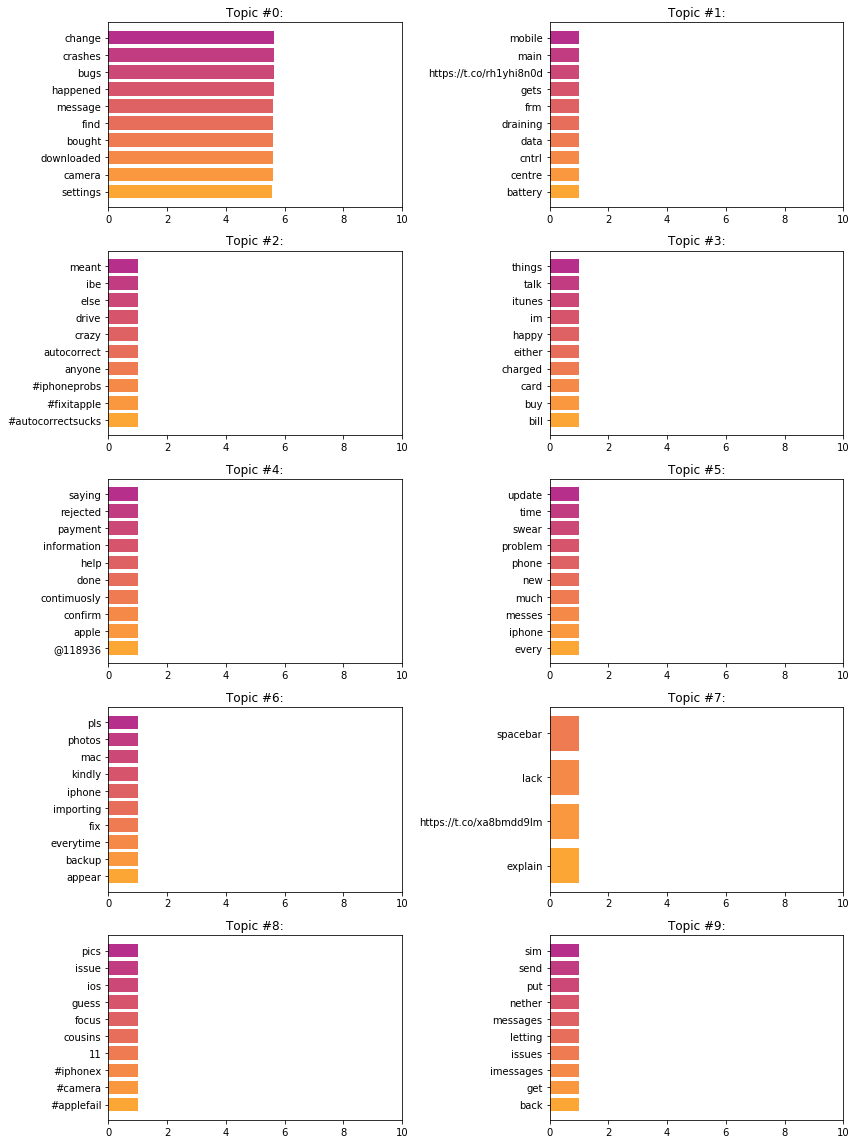

In [42]:
print_top_words_hierarchic(HCA, topic_max=10, n_top_words=10)

print_top_words_hierarchic_histo(HCA, topic_max=10, n_top_words=10)

# LSI

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=10000, min_df=2,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'how', 'have', 'doesn', 'of', 'between', "don't", 'a', 'has', 'each', "hadn't", 'having', 'being', 'now', 've', "shouldn't", 'itself', 'are', 'myself', 'on', 's', 'if', 'too', 'into', "it's", 'very', "shan't", 'once', 'at', "should've", "didn't", 'himself', 'to', "wasn't", 'off', 'ma', '...'couldn', 'him', 'for', 'wouldn', 'but', 'these', 'you', "she's", 'with', 'did', 'all', 'ourselves'},
        strip_accents=None,
        token_pattern='(?u)(?:http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\\(\\),]|(?:%[0-9a-f][0-9a-f]))+)|\x08\\w+|(?:(?:\\w|[@#])\\w+)',
        tokenizer=None, vocabulary=None)
n_samples: 74632, n_features: 10000
LSI Model:
Topic #0:
phone ios iphone update 11 fix new battery since please
Topic #1:


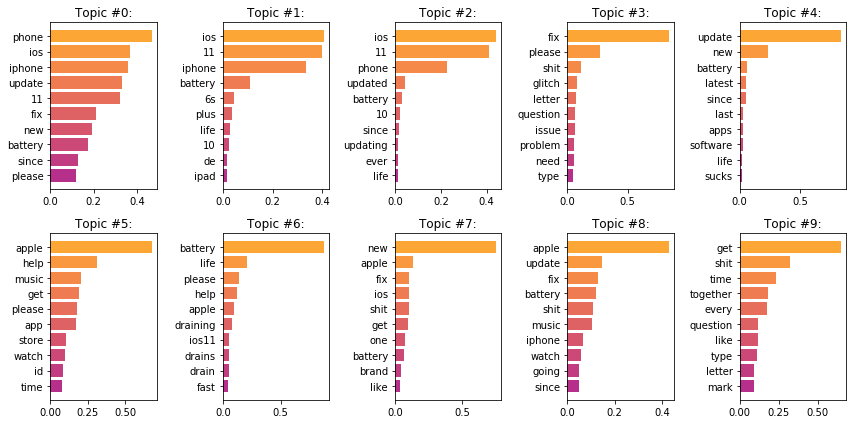


Contribution de chaque topic dans la représentation de Apple_text[0] :  [ 0.22086641  0.02635968 -0.10188786  0.06018119 -0.00434778  0.25865316
  0.02020417 -0.04173396  0.04759598  0.19431185]

un tweet à Apple :  @AppleSupport are these crashes me or you? #itsnotyouitsme 11.2 update and brand new #iPhonex https://t.co/f3rtGdVEPs
[[ 0.87274132  0.17052627  0.19509152 -0.1069884   0.98562736  0.05548472
  -0.22373829  0.48388923 -0.3252682  -0.1286011 ]]


In [43]:
from sklearn.decomposition import  TruncatedSVD
 
NUM_TOPICS = 10

vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=MaxFeature,
                                stop_words=stopWords, preprocessor=None, token_pattern=tweet_regex, 
                                lowercase = True, analyzer = 'word')
X = vectorizer.fit_transform(apple.text_x[:])

## Vérification du Vectorizer
print(vectorizer)

## Vérification des données
print("n_samples: %d, n_features: %d" % X.shape)
 
# Contruction du modèle LSI
lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(X)
print("LSI Model:")
print_top_words(lsi_model.components_, vectorizer.get_feature_names(), n_top_words=10)
print_top_words_histo(lsi_model.components_, vectorizer.get_feature_names(), n_top_words=10)
print()
# A quoi ressemble apple_text[0] and l'espase des topics construit par LSI
print("Contribution de chaque topic dans la représentation de Apple_text[0] : ", lsi_Z[0])
print()

## interprétation d'un tweet
text = apple.text_x[MaxTweet:MaxTweet+1]
print ("un tweet à Apple : ", text.values[0])
x = lsi_model.transform(vectorizer.transform(text))
print(x)      



In [44]:
## regardons les tweets les plus proches

from sklearn.metrics.pairwise import euclidean_distances
 
def most_similar(x, Z, top_n=5):
    dists = euclidean_distances(x.reshape(1, -1), Z)
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return most_similar
 
similarities = most_similar(x, lsi_Z)
document_id, similarity = similarities[0]
print(document_id)
print(similarity)
print(apple.text_x[document_id:document_id+1].values[0])

10000
0.0146561270909
@AppleSupport are these crashes me or you? #itsnotyouitsme 11.2 update and brand new #iPhonex https://t.co/f3rtGdVEPs


## Représentation en 2D des documents

In [45]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

Loading BokehJS ...

In [46]:
svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(X)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(apple.text_x))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=4, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

### Représentation des mots en 2D

In [47]:
svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(X.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=6, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)